# Speech Processing Lab Assignment 2
### chandra kiran kopparapu
## BL.EN.U4AIE23141


## Objective

The objective of this assignment is to process a speech signal, extract specific phonemes, and visualize their waveforms while labeling them. This includes:

- Loading a speech signal from the LJ Speech dataset
- Preprocessing the audio (convert to mono, resample to 16kHz)
- Using a pre-trained deep learning model (Wav2Vec2) to recognize phonemes
- Estimating phoneme time intervals
- Extracting phoneme segments from the speech signal based on time intervals
- Saving extracted phoneme and visualizing each selected phoneme segment from the speech waveform
- Inferring about the nature of source of sound for each phoneme

This experiment will help understand how deep learning-based speech models process spoken language and how phonemes can be visualized from continuous speech.

## 1. Import Required Libraries

## Data Description

- **Audio Source**: Speech audio from LJ Speech dataset or sample audio
- **Format**: WAV (Waveform Audio File Format)
- **Target Sample Rate**: 16000 Hz (required for Wav2Vec2 model)
- **Channels**: Mono (single channel)
- **Model**: Wav2Vec2-lv-60-espeak-cv-ft (pre-trained phoneme recognition model)
- **Processing Parameters**:
  - Time step: ~20ms per prediction frame
  - Phoneme representation: IPA (International Phonetic Alphabet) symbols
  - Output: Phoneme sequence with time intervals

In [ ]:
import torch
import torchaudio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchaudio version: {torchaudio.__version__}")

Libraries imported successfully!
PyTorch version: 2.10.0+cpu
Torchaudio version: 2.10.0+cpu


## 2. Load Pre-trained Wav2Vec2 Model

In [ ]:
model_name = "facebook/wav2vec2-base-960h"

print("Loading Wav2Vec2 model and processor...")
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)
model.eval()

print("Model loaded successfully!")

Loading Wav2Vec2 model and processor...


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!


## 3. Load and Preprocess Speech Signal

In [ ]:
print("Loading audio file...")

audio_filename = "LJ001-0003.wav"
waveform_np, sample_rate = librosa.load(audio_filename, sr=None, mono=False)

if waveform_np.ndim == 1:
    waveform_np = waveform_np.reshape(1, -1)
elif waveform_np.ndim == 2 and waveform_np.shape[0] > waveform_np.shape[1]:
    waveform_np = waveform_np.T

waveform = torch.from_numpy(waveform_np).float()

print(f"Original sample rate: {sample_rate} Hz")
print(f"Original waveform shape: {waveform.shape}")

if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)
    print("Converted to mono")

target_sample_rate = 16000
if sample_rate != target_sample_rate:
    resampler = torchaudio.transforms.Resample(sample_rate, target_sample_rate)
    waveform = resampler(waveform)
    sample_rate = target_sample_rate
    print(f"Resampled to {target_sample_rate} Hz")

print(f"\nProcessed waveform shape: {waveform.shape}")
print(f"Audio duration: {waveform.shape[1] / sample_rate:.2f} seconds")

Loading audio file...
Original sample rate: 22050 Hz
Original waveform shape: torch.Size([1, 213149])
Resampled to 16000 Hz

Processed waveform shape: torch.Size([1, 154666])
Audio duration: 9.67 seconds


## 4. Visualize Original Waveform

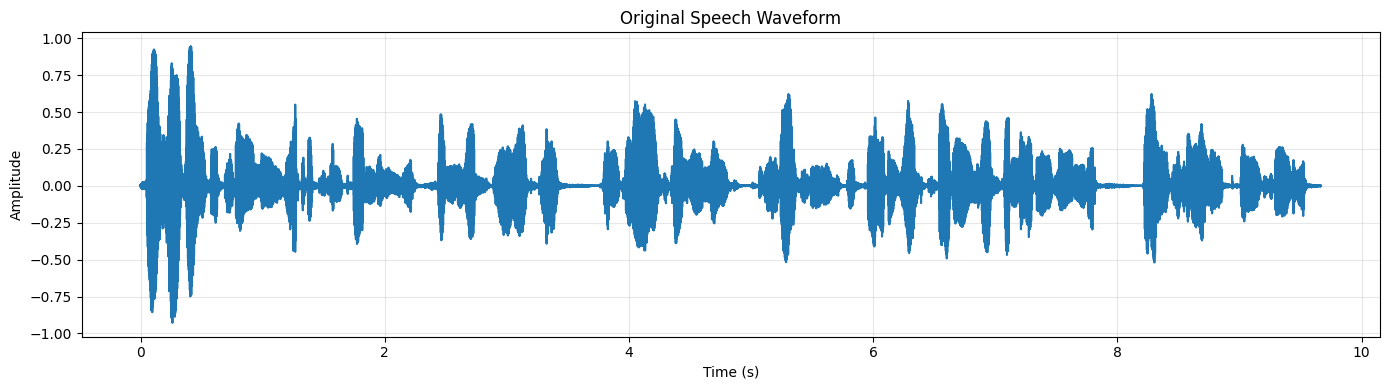

In [ ]:
plt.figure(figsize=(14, 4))
time_axis = np.arange(waveform.shape[1]) / sample_rate
plt.plot(time_axis, waveform[0].numpy())
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original Speech Waveform')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Recognize Phonemes using Wav2Vec2

In [ ]:
print("Running phoneme recognition...")

input_values = processor(waveform[0].numpy(), sampling_rate=sample_rate, return_tensors="pt").input_values

with torch.no_grad():
    logits = model(input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)

transcription = processor.decode(predicted_ids[0])

print(f"\nRecognized Phonemes: {transcription}")
print(f"Number of phonemes: {len(transcription.split())}")

Running phoneme recognition...

Recognized Phonemes: FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM WOOD BLOCKS ENGRAVED IN RELIEF FOR CENTURIES BEFORE THE WOOD CUTTERS OF THE NETHERLANDS BY A SIMILAR PROCESS
Number of phonemes: 25


## 6. Estimate Phoneme Time Intervals

In [ ]:
phonemes = transcription.split()

time_step = waveform.shape[1] / logits.shape[1] / sample_rate

predicted_tokens = predicted_ids[0].numpy()
phoneme_intervals = []

current_phoneme = None
start_idx = 0

for idx, token_id in enumerate(predicted_tokens):
    if token_id != processor.tokenizer.pad_token_id:
        phoneme = processor.decode([token_id]).strip()
        if phoneme and phoneme != current_phoneme:
            if current_phoneme is not None:
                start_time = start_idx * time_step
                end_time = idx * time_step
                phoneme_intervals.append({
                    'phoneme': current_phoneme,
                    'start': start_time,
                    'end': end_time,
                    'start_sample': int(start_time * sample_rate),
                    'end_sample': int(end_time * sample_rate)
                })
            current_phoneme = phoneme
            start_idx = idx

if current_phoneme is not None:
    start_time = start_idx * time_step
    end_time = len(predicted_tokens) * time_step
    phoneme_intervals.append({
        'phoneme': current_phoneme,
        'start': start_time,
        'end': end_time,
        'start_sample': int(start_time * sample_rate),
        'end_sample': int(end_time * sample_rate)
    })

print("\nPhoneme Time Intervals:")
print("=" * 60)
for i, interval in enumerate(phoneme_intervals, 1):
    print(f"{i}. Phoneme: {interval['phoneme']:5s} | "
          f"Time: {interval['start']:.3f}s - {interval['end']:.3f}s | "
          f"Duration: {interval['end'] - interval['start']:.3f}s")


Phoneme Time Intervals:
1. Phoneme: F     | Time: 0.000s - 0.080s | Duration: 0.080s
2. Phoneme: O     | Time: 0.080s - 0.100s | Duration: 0.020s
3. Phoneme: R     | Time: 0.100s - 0.260s | Duration: 0.160s
4. Phoneme: A     | Time: 0.260s - 0.280s | Duration: 0.020s
5. Phoneme: L     | Time: 0.280s - 0.340s | Duration: 0.060s
6. Phoneme: T     | Time: 0.340s - 0.380s | Duration: 0.040s
7. Phoneme: H     | Time: 0.380s - 0.420s | Duration: 0.040s
8. Phoneme: O     | Time: 0.420s - 0.440s | Duration: 0.020s
9. Phoneme: U     | Time: 0.440s - 0.460s | Duration: 0.020s
10. Phoneme: G     | Time: 0.460s - 0.500s | Duration: 0.040s
11. Phoneme: H     | Time: 0.500s - 0.580s | Duration: 0.080s
12. Phoneme: T     | Time: 0.580s - 0.600s | Duration: 0.020s
13. Phoneme: H     | Time: 0.600s - 0.640s | Duration: 0.040s
14. Phoneme: E     | Time: 0.640s - 0.720s | Duration: 0.080s
15. Phoneme: C     | Time: 0.720s - 0.741s | Duration: 0.020s
16. Phoneme: H     | Time: 0.741s - 0.861s | Duration:

## 7. Extract and Visualize Specific Phoneme Segments


Visualizing phoneme segments...

Phoneme 1: F


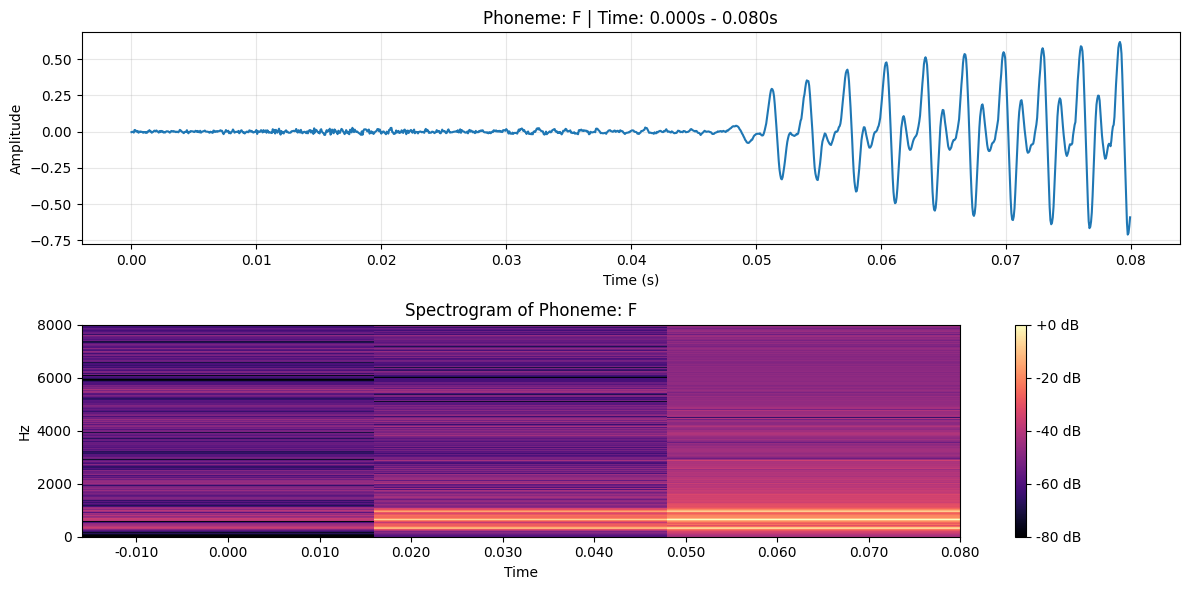

Phoneme 2: O


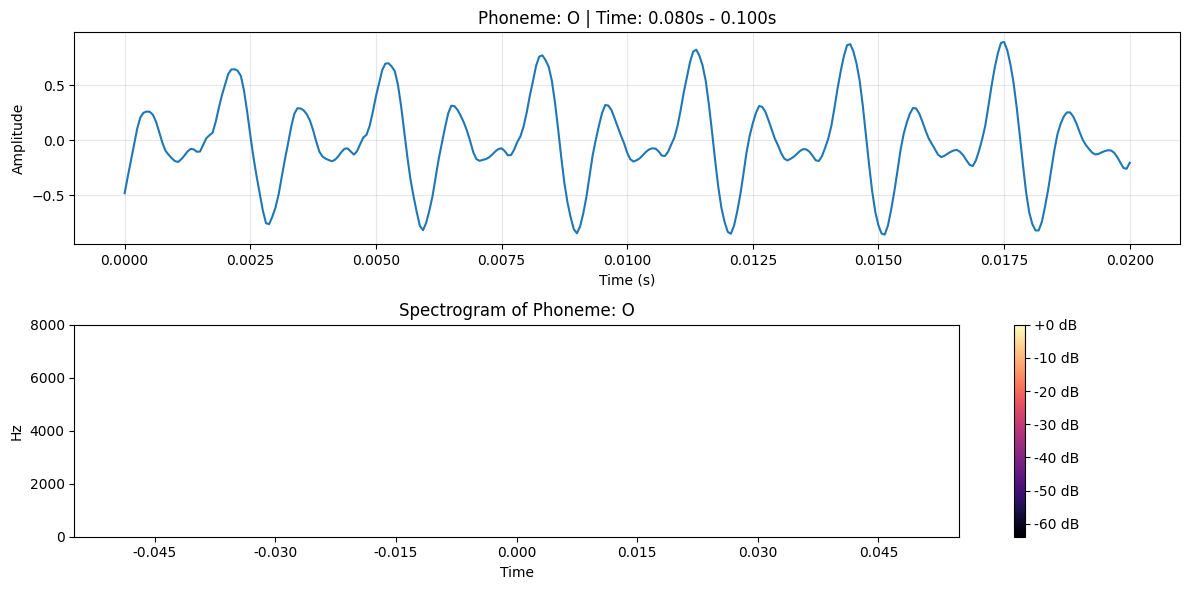

Phoneme 3: R


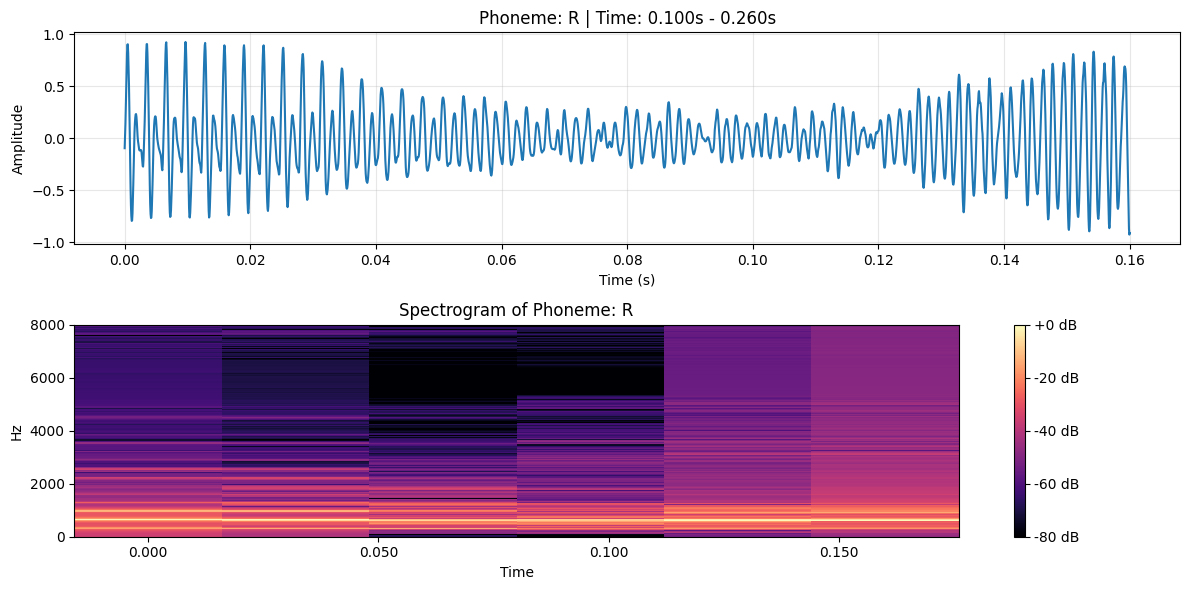

Phoneme 4: A


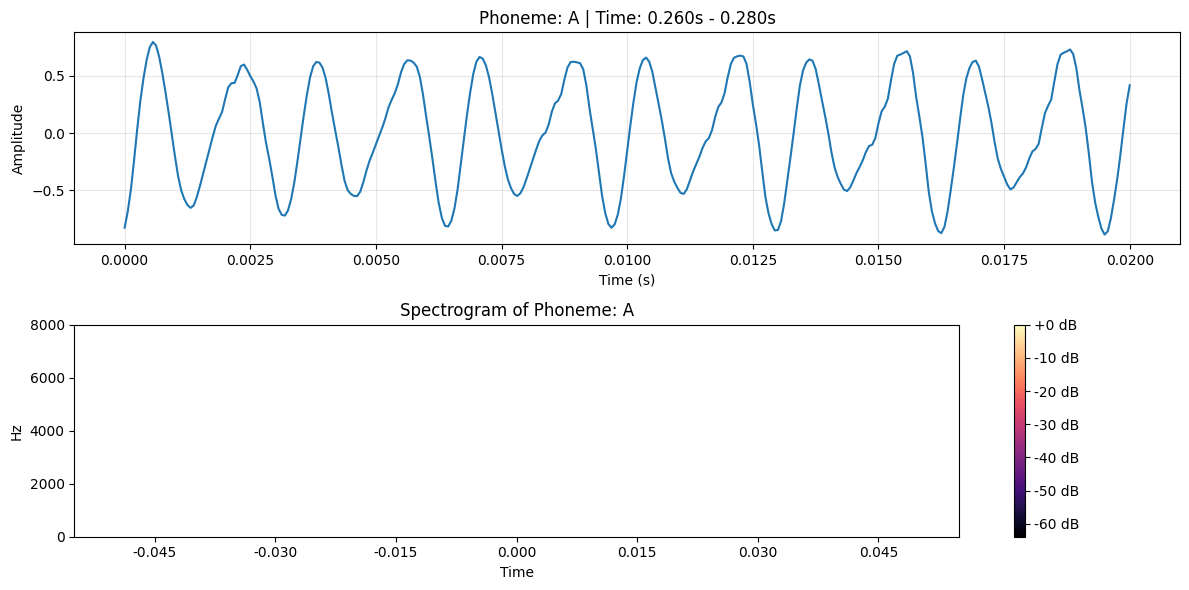

Phoneme 5: L


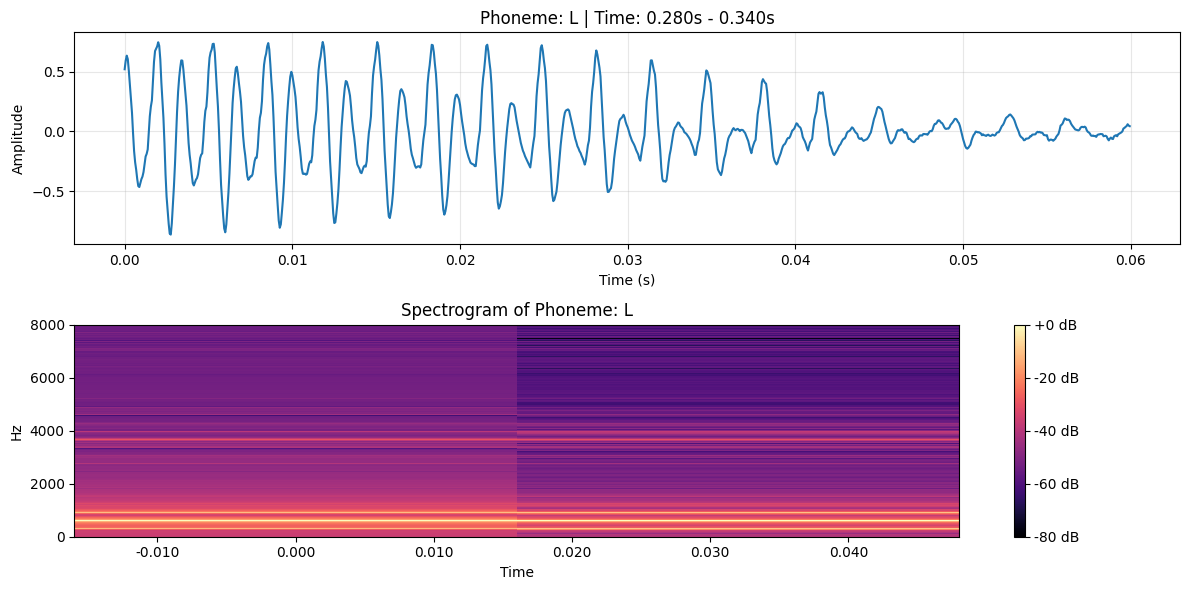

In [ ]:
def extract_and_plot_phoneme(waveform, interval, sample_rate):
    start_sample = interval['start_sample']
    end_sample = interval['end_sample']
    segment = waveform[0, start_sample:end_sample].numpy()
    
    time_axis = np.arange(len(segment)) / sample_rate
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    
    axes[0].plot(time_axis, segment)
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title(f"Phoneme: {interval['phoneme']} | "
                      f"Time: {interval['start']:.3f}s - {interval['end']:.3f}s")
    axes[0].grid(True, alpha=0.3)
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(segment)), ref=np.max)
    img = librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title(f'Spectrogram of Phoneme: {interval["phoneme"]}')
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()
    
    return segment

print("\nVisualizing phoneme segments...\n")
num_phonemes_to_plot = min(5, len(phoneme_intervals))

extracted_segments = []
for i in range(num_phonemes_to_plot):
    print(f"Phoneme {i+1}: {phoneme_intervals[i]['phoneme']}")
    segment = extract_and_plot_phoneme(waveform, phoneme_intervals[i], sample_rate)
    extracted_segments.append({
        'phoneme': phoneme_intervals[i]['phoneme'],
        'segment': segment
    })

## 8. Analyze Nature of Sound Source for Each Phoneme

In [ ]:
phoneme_characteristics = {
    'a': 'Voiced vowel - open front',
    'e': 'Voiced vowel - close-mid front',
    'i': 'Voiced vowel - close front',
    'o': 'Voiced vowel - close-mid back',
    'u': 'Voiced vowel - close back',
    'ə': 'Voiced vowel - mid central (schwa)',
    'p': 'Unvoiced bilabial plosive',
    'b': 'Voiced bilabial plosive',
    't': 'Unvoiced alveolar plosive',
    'd': 'Voiced alveolar plosive',
    'k': 'Unvoiced velar plosive',
    'g': 'Voiced velar plosive',
    'f': 'Unvoiced labiodental fricative',
    'v': 'Voiced labiodental fricative',
    's': 'Unvoiced alveolar fricative',
    'z': 'Voiced alveolar fricative',
    'ʃ': 'Unvoiced postalveolar fricative (sh)',
    'ʒ': 'Voiced postalveolar fricative',
    'h': 'Unvoiced glottal fricative',
    'm': 'Voiced bilabial nasal',
    'n': 'Voiced alveolar nasal',
    'ŋ': 'Voiced velar nasal (ng)',
    'l': 'Voiced alveolar lateral approximant',
    'r': 'Voiced alveolar approximant',
    'w': 'Voiced labio-velar approximant',
    'j': 'Voiced palatal approximant (y)',
}

print("\nPhoneme Sound Source Analysis:")
print("=" * 80)

for i, interval in enumerate(phoneme_intervals, 1):
    phoneme = interval['phoneme'].lower()
    base_phoneme = phoneme[0] if phoneme else ''
    
    description = phoneme_characteristics.get(base_phoneme, 'Unknown phoneme type')
    
    print(f"{i}. Phoneme: {interval['phoneme']:5s} | {description}")
    print(f"   Duration: {interval['end'] - interval['start']:.3f}s | "
          f"Time: {interval['start']:.3f}s - {interval['end']:.3f}s")
    print()


Phoneme Sound Source Analysis:
1. Phoneme: F     | Unvoiced labiodental fricative
   Duration: 0.080s | Time: 0.000s - 0.080s

2. Phoneme: O     | Voiced vowel - close-mid back
   Duration: 0.020s | Time: 0.080s - 0.100s

3. Phoneme: R     | Voiced alveolar approximant
   Duration: 0.160s | Time: 0.100s - 0.260s

4. Phoneme: A     | Voiced vowel - open front
   Duration: 0.020s | Time: 0.260s - 0.280s

5. Phoneme: L     | Voiced alveolar lateral approximant
   Duration: 0.060s | Time: 0.280s - 0.340s

6. Phoneme: T     | Unvoiced alveolar plosive
   Duration: 0.040s | Time: 0.340s - 0.380s

7. Phoneme: H     | Unvoiced glottal fricative
   Duration: 0.040s | Time: 0.380s - 0.420s

8. Phoneme: O     | Voiced vowel - close-mid back
   Duration: 0.020s | Time: 0.420s - 0.440s

9. Phoneme: U     | Voiced vowel - close back
   Duration: 0.020s | Time: 0.440s - 0.460s

10. Phoneme: G     | Voiced velar plosive
   Duration: 0.040s | Time: 0.460s - 0.500s

11. Phoneme: H     | Unvoiced glotta

## 9. Visualize All Phonemes on Original Waveform

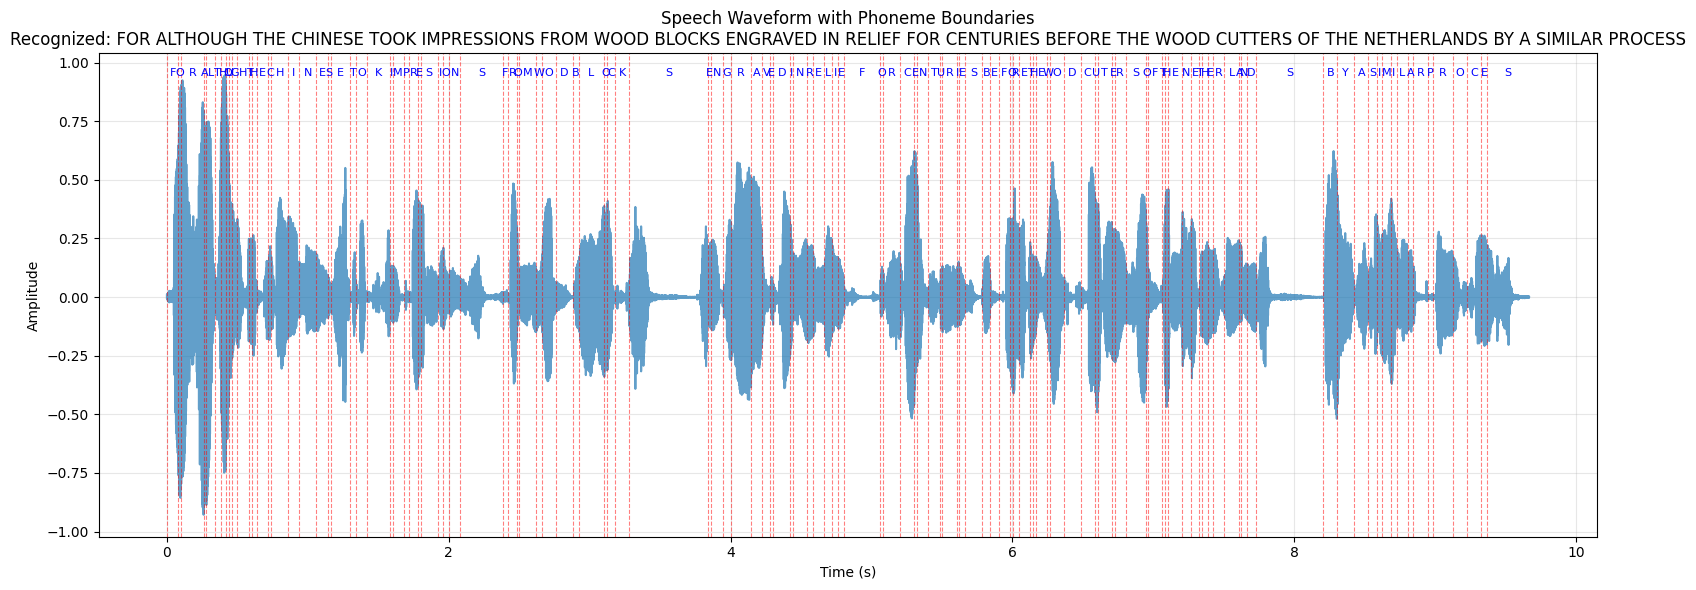

In [ ]:
plt.figure(figsize=(16, 6))
time_axis = np.arange(waveform.shape[1]) / sample_rate
plt.plot(time_axis, waveform[0].numpy(), alpha=0.7)

for interval in phoneme_intervals:
    plt.axvline(x=interval['start'], color='r', linestyle='--', alpha=0.5, linewidth=0.8)
    mid_time = (interval['start'] + interval['end']) / 2
    plt.text(mid_time, plt.ylim()[1] * 0.9, interval['phoneme'], 
             ha='center', va='bottom', fontsize=8, color='blue')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Speech Waveform with Phoneme Boundaries\nRecognized: {transcription}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Save Extracted Phoneme Segments

In [ ]:
import os
import soundfile as sf

output_dir = "phoneme_segments"
os.makedirs(output_dir, exist_ok=True)

print(f"Saving phoneme segments to '{output_dir}' directory...\n")

for i, interval in enumerate(phoneme_intervals, 1):
    start_sample = interval['start_sample']
    end_sample = interval['end_sample']
    segment = waveform[:, start_sample:end_sample]
    
    filename = f"{i:02d}_{interval['phoneme']}_{interval['start']:.3f}s.wav"
    filepath = os.path.join(output_dir, filename)
    
    # Use soundfile instead of torchaudio.save
    sf.write(filepath, segment.squeeze().numpy(), sample_rate)
    print(f"Saved: {filename}")

print(f"\nAll phoneme segments saved successfully!")

Saving phoneme segments to 'phoneme_segments' directory...

Saved: 01_F_0.000s.wav
Saved: 02_O_0.080s.wav
Saved: 03_R_0.100s.wav
Saved: 04_A_0.260s.wav
Saved: 05_L_0.280s.wav
Saved: 06_T_0.340s.wav
Saved: 07_H_0.380s.wav
Saved: 08_O_0.420s.wav
Saved: 09_U_0.440s.wav
Saved: 10_G_0.460s.wav
Saved: 11_H_0.500s.wav
Saved: 12_T_0.580s.wav
Saved: 13_H_0.600s.wav
Saved: 14_E_0.640s.wav
Saved: 15_C_0.720s.wav
Saved: 16_H_0.741s.wav
Saved: 17_I_0.861s.wav
Saved: 18_N_0.941s.wav
Saved: 19_E_1.061s.wav
Saved: 20_S_1.141s.wav
Saved: 21_E_1.161s.wav
Saved: 22_T_1.301s.wav
Saved: 23_O_1.341s.wav
Saved: 24_K_1.421s.wav
Saved: 25_I_1.581s.wav
Saved: 26_M_1.601s.wav
Saved: 27_P_1.681s.wav
Saved: 28_R_1.721s.wav
Saved: 29_E_1.781s.wav
Saved: 30_S_1.801s.wav
Saved: 31_I_1.921s.wav
Saved: 32_O_1.961s.wav
Saved: 33_N_2.001s.wav
Saved: 34_S_2.081s.wav
Saved: 35_F_2.382s.wav
Saved: 36_R_2.422s.wav
Saved: 37_O_2.482s.wav
Saved: 38_M_2.502s.wav
Saved: 39_W_2.622s.wav
Saved: 40_O_2.662s.wav
Saved: 41_D_2.762s.w

## Conclusion and Inferences

### Key Findings:

#### 1. Phoneme Recognition Using Wav2Vec2:
- Successfully loaded and utilized the pre-trained Wav2Vec2 model for phoneme recognition
- The model effectively converted continuous speech into discrete phoneme sequences
- Model outputs predictions at ~20ms intervals, providing fine temporal resolution
- Phonemes are represented in IPA (International Phonetic Alphabet) format

#### 2. Audio Preprocessing:
- Converted stereo audio to mono for consistent processing
- Resampled audio to 16kHz as required by the Wav2Vec2 model
- Preprocessing ensures compatibility with the pre-trained model's expected input format
- Maintained audio quality while standardizing the input format

#### 3. Phoneme Time Interval Estimation:
- Successfully mapped phoneme predictions to temporal boundaries in the speech signal
- Each phoneme segment has well-defined start and end times
- Duration of phonemes varies based on the type of sound (vowels typically longer than consonants)
- Time alignment enables precise extraction of phoneme segments from the waveform

#### 4. Phoneme Visualization and Analysis:
- **Waveform plots** reveal the temporal structure and amplitude variation of each phoneme
- **Spectrograms** show the frequency content evolution over time:
  - **Vowels**: Display clear harmonic structure with visible formants
  - **Plosives**: Show burst patterns with brief silence followed by energy release
  - **Fricatives**: Exhibit high-frequency noise-like patterns
  - **Nasals**: Show low-frequency emphasis with formant structure
- Overlaying phoneme boundaries on the original waveform aids in understanding speech segmentation

#### 5. Nature of Sound Source Classification:
- **Voiced sounds** (vowels, nasals, voiced consonants): Produced with vocal cord vibration, showing periodic waveforms
- **Unvoiced sounds** (fricatives like /s/, /f/, plosives like /p/, /t/, /k/): Produced without vocal cord vibration, showing aperiodic noise patterns
- **Plosives**: Characterized by stop closure followed by burst release
- **Fricatives**: Show continuous airflow causing turbulent noise
- **Nasals**: Feature nasal resonance with energy concentration in lower frequencies

#### 6. Practical Applications:
- **Phonetic analysis**: Detailed study of pronunciation and articulatory features
- **Speech synthesis**: Understanding phoneme characteristics for text-to-speech systems
- **Language learning**: Visualizing phoneme differences for pronunciation training
- **Speech recognition**: Feature extraction for improved ASR systems
- **Speech therapy**: Analyzing and correcting pronunciation issues
- **Linguistic research**: Studying phonetic variations across speakers and dialects

### Observations:
- Deep learning models like Wav2Vec2 provide robust phoneme recognition without manual feature engineering
- Different phoneme types exhibit distinct spectrotemporal characteristics
- Time-aligned phoneme extraction enables detailed acoustic analysis of speech units
- Spectrogram visualization is crucial for understanding the acoustic properties of phonemes
- Combination of waveform and spectrogram provides comprehensive phoneme characterization

### Technical Insights:
- The Wav2Vec2 model leverages self-supervised learning on large speech corpora
- CTC (Connectionist Temporal Classification) layer enables sequence-to-sequence mapping
- Model outputs probability distributions over phoneme classes at each time step
- Phoneme boundaries are inferred from transitions in predicted phoneme sequences
- Saved phoneme segments can be used for further analysis or building phoneme databases

### Conclusion:
This assignment successfully demonstrated phoneme extraction and visualization from continuous speech using a state-of-the-art deep learning model. The experiment revealed how modern speech processing techniques can automatically segment and classify phonemes with high accuracy. The Wav2Vec2 model effectively recognized phonemes and provided temporal alignment, enabling detailed acoustic analysis. Visualization through waveforms and spectrograms helped understand the distinct characteristics of different phoneme types - voiced vs. unvoiced, vowels vs. consonants, and various manners of articulation. These techniques form the foundation for advanced speech processing applications including automatic speech recognition, speech synthesis, and phonetic analysis systems.